<a href="https://colab.research.google.com/github/SwordPy/DeepLearning/blob/master/PokeDex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import layer_utils, np_utils
from sklearn.metrics import confusion_matrix, classification_report  
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import seaborn as sn 
import pickle
import os
import re
import tensorflow as tf
import cv2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# DIRECTORIO DONDE SE ENCUENTRAN LAS IMÁGENES A ENTRENAR/VALIDAR
train_data_dir = "XXXXXXXXXXXXX"

In [0]:
#ESTABLECER EL DIRECTORIO EN EL QUE QUIERO TRABAJAR
#os.chdir("/content/drive/My Drive/DatasetsColab/Pokemon_finalTest/Nivel_Basico_Desarrollo_Pokedex/dataset" )

In [0]:
img_width, img_height = 64, 64
epochs = 100 
batch_size = 15 # ENTRENARÁ LA RED EN PAQUETES DE 15 Y VOLVERÁ A COGER 15 Y ENTRENAR Y ASÍ....
lr = 1e-3

In [0]:
# SE APROVECHA EL HECHO DE TENER LAS ETIQUETAS EN LAS MISMAS CARPETAS DESTINO -> FLOW_FROM_DIRECTORY
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    rotation_range = 5,
    width_shift_range=0.1,
    horizontal_flip = True,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split = 0.1)

train_generator = train_datagen.flow_from_directory( 
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode  = "categorical",
    subset = "training")

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode  = "categorical",
    subset = "validation")

Found 1123 images belonging to 5 classes.
Found 122 images belonging to 5 classes.


In [0]:
print(train_generator.samples)

In [0]:
######################################################################################################################
# SUPRIMIENDO LA CAPA DENSA DE 512 NEURONAS Y 150 EPOCHS CON BS DE 32 SE OBTIENEN TAMBIÉN BUENOS RESULTADOS, 
# PERO LA SIGUIENTE ES MÁS EFICIENTE AUNQUE MÁS TARDÍA.
######################################################################################################################
model = Sequential()

#Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), padding="same", activation = "relu"))
model.add (BatchNormalization ()) 
model.add(MaxPooling2D(pool_size=(3, 3),padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),padding="same", activation ="relu"))
model.add (BatchNormalization ()) 
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid')) #
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),padding="same", activation ="relu"))
model.add (BatchNormalization ()) 
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid')) 
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(128, (3, 3), padding="same", activation ="relu"))
model.add (BatchNormalization ()) 
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid')) 

model.add(Conv2D(128, (3, 3),padding="same", activation ="relu"))
model.add (BatchNormalization ()) 
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid')) 
model.add(Dropout(0.25))

#Layer 3 - FLATTEN
model.add(Flatten(input_shape=(img_width, img_height, 3), name="Input_layer")) 

model.add(Dense(1024, activation='relu', name="Hidden_layer_1"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu', name="Hidden_layer_2"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu', name="Hidden_layer_3"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax', name="Output_layer")) 

#Resumen de mi red neuronal
model.summary()

In [0]:
def Check_image(image):
  print("\n")
  print("##############################")
  print("   VALIDACIÓN DE IMAGEN")
  print("##############################")
  print("\n")

  #COMPROBAMOS CÓMO DE BUENO ES CON UNA IMAGEN EXTERNA
  print("[INFO]: Cargando imagen a procesar...")
  print("\n")
  #CARGAMOS LA IMAGEN GRACIAS A LA LIBRERIA CV2 Y LO PASAMOS A UNA IMAGEN RGB
  img_path = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"+image
  img_test = cv2.imread(img_path, cv2.IMREAD_COLOR) # Leo imagen con OPENCV
  img_test = cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB) # Por defecto la carga en BGR, la convierto a RGB por usar OPENCV

  plt.imshow(img_test) #MOSTRAMOS IMAGEN
  plt.show()

  #PRE-PROCESAMOS TALY COMO SE HA HECHO PARA LA FASE DE ENTRENAMIENTO, LE HACEMOS MISMO CAMBIO A LA IMAGEN QUE LAS DE DENTRO
  img_test = img_test.astype("float") / 255.0 #(X)
  #RE-ESCALAMOS LA IMAGEN AL TAMAÑO QUE FUE ENTRENADA (comando cv2.resize)
  img_test_res = cv2.resize(img_test, (img_width, img_height))

  print("############################\n")
  print("################\n")
  print("######\n")

  labelNames = ["Bulbasaur", "Charmander", "Mewtwo", "Pikachu", "Squirtle"]

  output = img_test_res.copy()

  image = np.expand_dims(img_test_res, axis=0) #Expando porque así le indico que le voy a meter 1 foto (1, ....)

  # Clasificación de la imagen empleando el modelo
  print("[INFO]: Clasificando imagen...")
  print("\n")

  proba = model.predict(image) #(X)
  print("Las probabilidades son {}".format(proba))

  # Nos quedamos con la clase que presente una probabilidad mayor y buscamos la etiqueta en el vector labelNames
  index = np.argmax(proba) #(X)
  print("\nLA CLASE CON MAYOR PROBABILIDAD ES LA {}".format(index))
  label = labelNames[index] #(X)
  print("\n--> ¡¡UN {} SALVAJE APARECIÓ!! <-- ".format(label))

  #NO HARÍA FALTA LA VERDAD ABSOLUTA PORQUE YA LO ESTOY VIENDO YO MISMO
  #gt = labelNames[train_generator.classes[8]] #0

  # Mostrando imagen e información
  #label = "Predicción: {} - Confianza: {:.2f}% - Ground Truth: {}".format(label, proba[0][index] * 100, gt)
  label = "Predicción: {} - Confianza: {:.2f}%\n".format(label, proba[0][index] * 100)

  plt.imshow(output)
  plt.title(label)
  plt.show()

In [0]:
#COMPILAMOS MODELO Y LO ENTRENAMOS
print("[INFO]: Entrenando red neuronal\n")

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["acc"])

H = model.fit_generator(  
    train_generator,
    epochs = epochs,
    steps_per_epoch = (train_generator.samples * 0.9 * 2)/batch_size, #90% entrenamiento - 2 modificaciones a cada imagen
    validation_data = validation_generator,
    verbose = 1)

print("##############################")
print("   RESULTADOS DEL MODELO")
print("##############################")
print("\n")

#EVALUACIÓN DEL MODELO
print("[INFO]: Evaluando el modelo...")

plt.style.use("ggplot")
plt.figure()

plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["acc"], label="train_acc")
plt.plot(H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Check_image("bulb_img.jpg")

In [0]:
# MÚLTIPLES COMPROBACIONES EN EL MISMO MOMENTO QUE SE ENTRENA LA RED NEURONAL
names = ["xxxx.jpg","xxx.png","xxx.jpeg","xxxx.png","xxx.png","xxx.jpg",
         "xxxx.jpg","xxxx.jpg","xxxx.png","xxx.png","xxx.png"]
for i in range(0,len(names)):
  print("###########################")
  Check_image(names[i])

In [0]:
#Almacenamos el modelo empleando la función model.save de Keras
model.save("XXXXXXXXXXXXXXXXXXXXX/XXXXXXXXXXXXXX.h5")

# PREDICCIÓN DE IMÁGENES (CARGA DEL MODELO .h5)

##############################
   RESULTADOS DEL MODELO
##############################


[INFO]: Cargando imagen a procesar...

######

################

############################


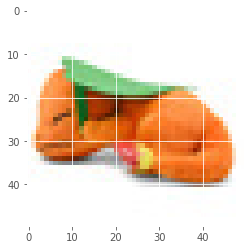

############################

################

######

[INFO]: Clasificando imagen...

Las probabilidades son [[0.00823648 0.9612766  0.00318428 0.01660993 0.0106927 ]]

LA CLASE CON MAYOR PROBABILIDAD ES LA 1

--> ¡UN CHARMANDER SALVAJE APARECIÓ! <-- 



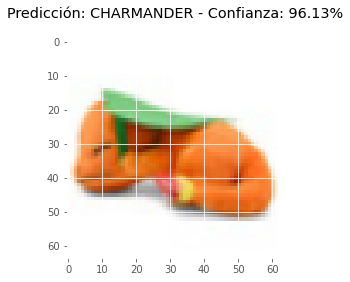

In [0]:
def predict_image(image,model):
  print("##############################")
  print("   RESULTADOS DEL MODELO")
  print("##############################")

  print("\n")

  #COMPROBAMOS CÓMO DE BUENO ES CON UNA IMAGEN EXTERNA
  print("[INFO]: Cargando imagen a procesar...\n")
  print("######\n")
  print("################\n")
  print("############################")
  
  #CARGAMOS LA IMAGEN GRACIAS A LA LIBRERIA CV2 Y LO PASAMOS A UNA IMAGEN RGB
  img_path = "XXXXXXXXXXXXXXXXXXXXXXXX"+image
  img_test = cv2.imread(img_path, cv2.IMREAD_COLOR) # Leo imagen con OPENCV
  img_test = cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB) # Por defecto la carga en BGR, la convierto a RGB por usar OPENCV

  plt.imshow(img_test) #MOSTRAMOS IMAGEN
  plt.style.use("ggplot")
  plt.show()

  #PRE-PROCESAMOS TALY COMO SE HA HECHO PARA LA FASE DE ENTRENAMIENTO, LE HACEMOS MISMO CAMBIO A LA IMAGEN QUE LAS DE DENTRO
  img_test = img_test.astype("float") / 255.0 #(X)
  #RE-ESCALAMOS LA IMAGEN AL TAMAÑO QUE FUE ENTRENADA (comando cv2.resize)
  img_test_res = cv2.resize(img_test, (img_width, img_height)) #(X)

  print("############################\n")
  print("################\n")
  print("######\n")

  labelNames = ["BULBASAUR", "CHARMANDER", "MEWTWO", "PIKACHU", "SQUIRTLE"]

  output = img_test_res.copy()

  image = np.expand_dims(img_test_res, axis=0) #Expando porque así le indico que le voy a meter 1 foto (1, ....)

  # Clasificación de la imagen empleando el modelo
  print("[INFO]: Clasificando imagen...\n")

  proba = model.predict(image) #(X)
  print("Las probabilidades son {}".format(proba))

  # Nos quedamos con la clase que presente una probabilidad mayor y buscamos la etiqueta en el vector labelNames
  index = np.argmax(proba) #(X)
  print("\nLA CLASE CON MAYOR PROBABILIDAD ES LA {}".format(index))
  label = labelNames[index] #(X)
  print("\n--> ¡UN {} SALVAJE APARECIÓ! <-- \n".format('\033[1m'+label+'\033[0m'))

  #NO HARÍA FALTA LA VERDAD ABSOLUTA PORQUE YA LO ESTOY VIENDO YO MISMO
  #gt = labelNames[train_generator.classes[8]] #0

  # Mostrando imagen e información
  #label = "Predicción: {} - Confianza: {:.2f}% - Ground Truth: {}".format(label, proba[0][index] * 100, gt)
  label = "Predicción: {} - Confianza: {:.2f}%\n".format(label, proba[0][index] * 100)

  plt.style.use("ggplot")
  plt.imshow(output)
  plt.title(label)
  plt.show()

#CARGAMOS EL MODELO CON EL QUE HA APRENDIDO (DESCOMENTAMOS LO DE BAJO CUANDO SE HAYA CERRADO LA SESION)
model = load_model("XXXXXXXXXXXXXXX/XXXXXX.h5")

predict_image("XXXXXX.jpg",model)